# code_2_MFGP_1 Cokriging with nested sampling
* Author: Songho Lee
* PI: Seunghwa Ryu
* References
    - https://github.com/SMTorg/smt/tree/master/tutorial#readme
    - https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/MultiFi/SMT_MFK_tutorial.ipynb

In [1]:
# ! pip install smt

# Forrester function
- Forrester, A., Sobester, A., & Keane, A. (2008). Engineering design via surrogate modelling: a practical guide. Wiley. 

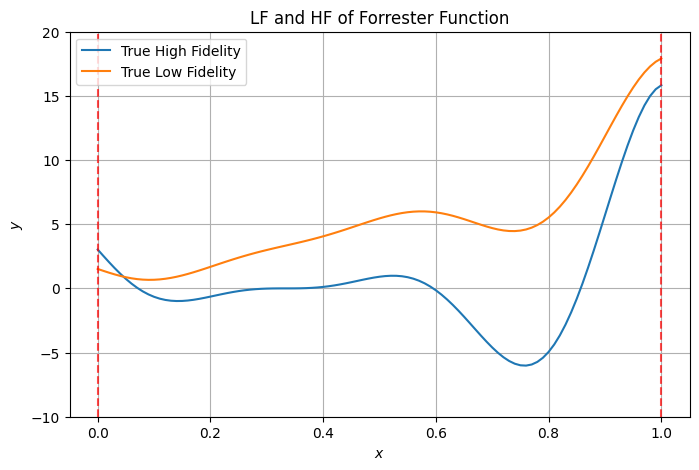

In [2]:
from smt.applications import MFK
import numpy as np
from matplotlib import pyplot as plt
from smt.applications.mfk import NestedLHS
from smt.surrogate_models import KRG
%matplotlib inline

def HF_function(x): # Forrester function
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 + 5

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
y_hf = HF_function(x)
y_lf = LF_function(x)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x, y_hf, label="True High Fidelity")
ax.plot(x, y_lf, label="True Low Fidelity")
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("LF and HF of Forrester Function")
ax.legend(loc='upper left')
ax.grid(True)
ax.set_ylim([-10,20])
plt.show()
plt.close()

# Nested Sampling

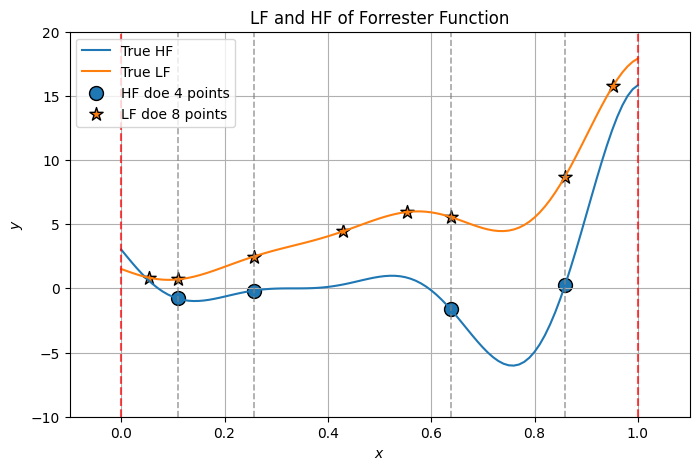

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from smt.applications.mfk import NestedLHS

# Nested DOE
# LHS sampling with 2 levels of fidelity
ndim = 1  # 1 dimension example
nlvl = 2  # 2 levels
ndoe_HF = 4  # 4 high fidelity points

xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=2)
Xt_c, Xt_e = xdoes(ndoe_HF)
ndoe_LF = np.shape(Xt_c)[0]

def HF_function(x):  # Forrester function
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)

def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 + 5

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

y_hf = HF_function(x)
y_lf = LF_function(x)

yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y_hf, label="True HF", color="C0")
ax.plot(x, y_lf, linestyle="-", label="True LF", color="C1")
ax.scatter(Xt_e, yt_e, marker="o", color="C0", label=f"HF doe {ndoe_HF} points", s=100, edgecolor='k')
ax.scatter(Xt_c, yt_c, marker="*", color="C1", label=f"LF doe {ndoe_LF} points", s=100, edgecolor='k')
for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("LF and HF of Forrester Function")
ax.legend(loc='upper left')
ax.grid(True)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
plt.show()
plt.close()

# 2-Level Multi Fidelity Kriging (MFK) model

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0668240
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0199335
___________________________________________________________________________
   
                                    MFK
______________________________________________________

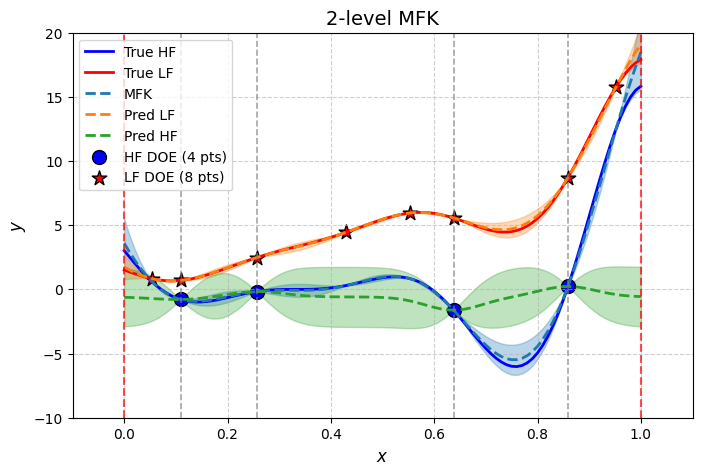

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from smt.surrogate_models import KRG
from smt.applications import MFK

# Build the Low-Fidelity Kriging model
gp_LF = KRG(theta0=Xt_c.shape[1] * [1.0])
gp_LF.set_training_values(Xt_c, yt_c)
gp_LF.train()

# Build the High-Fidelity Kriging model
gp_HF = KRG(theta0=Xt_e.shape[1] * [1.0])
gp_HF.set_training_values(Xt_e, yt_e)
gp_HF.train()

# Build the Multi-Fidelity Kriging (MFK) model
sm = MFK(theta0=Xt_e.shape[1] * [1.0])
sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_e, yt_e)
sm.train()

# Test points
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# Predictions
y = sm.predict_values(x)
MSE = sm.predict_variances(x)

ypred_LF = gp_LF.predict_values(x)
ypred_HF = gp_HF.predict_values(x)

MSE_LF = gp_LF.predict_variances(x)
MSE_HF = gp_HF.predict_variances(x)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, HF_function(x), linestyle="-", label="True HF", color="b", linewidth=2)
ax.plot(x, LF_function(x), linestyle="-", label="True LF", color="r", linewidth=2)

# Multi-Fidelity Kriging (MFK) Prediction
ax.plot(x, y, linestyle="--", label="MFK", color="C0", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(MSE)),
    np.ravel(y + 3 * np.sqrt(MSE)),
    color="C0",
    alpha=0.3,
    # label="MFK 99% Confidence Interval",
)

# Low-Fidelity Prediction
ax.plot(x, ypred_LF, linestyle="--", label="Pred LF", color="C1", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(ypred_LF - 3 * np.sqrt(MSE_LF)),
    np.ravel(ypred_LF + 3 * np.sqrt(MSE_LF)),
    color="C1",
    alpha=0.3,
    # label="LF 99% Confidence Interval",
)

# High-Fidelity Prediction
ax.plot(x, ypred_HF, linestyle="--", label="Pred HF", color="C2", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(ypred_HF - 3 * np.sqrt(MSE_HF)),
    np.ravel(ypred_HF + 3 * np.sqrt(MSE_HF)),
    color="C2",
    alpha=0.3,
    # label="HF 99% Confidence Interval",
)

# Scatter points for HF and LF DOE
ax.scatter(Xt_e, yt_e, marker="o", color="b", edgecolor="k", s=100, label=f"HF DOE ({ndoe_HF} pts)")
ax.scatter(Xt_c, yt_c, marker="*", color="r", edgecolor="k", s=120, label=f"LF DOE ({ndoe_LF} pts)")

for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel(r"$x$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
ax.set_title("2-level MFK", fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)

# Set axis limits
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)

# Show the plot
plt.show()
plt.close()

# 3-Level Multi Fidelity Kriging (MFK) model

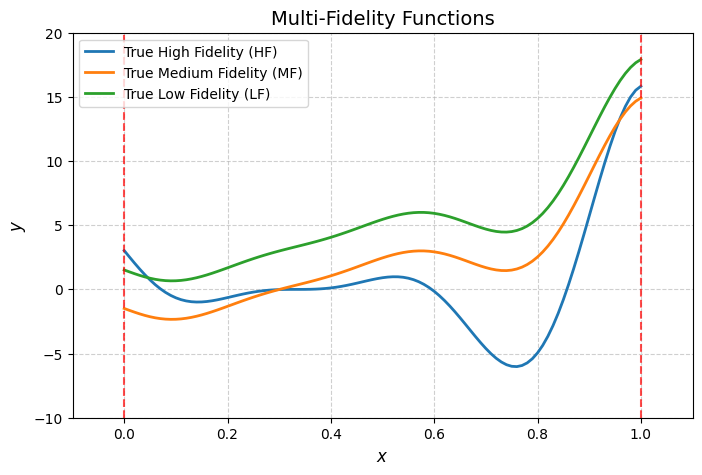

In [5]:
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 + 5
def MF_function(x):
    return LF_function(x) - 3
def HF_function(x):
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, HF_function(x), "-", label="True High Fidelity (HF)", color="C0", linewidth=2)
ax.plot(x, MF_function(x), "-", label="True Medium Fidelity (MF)", color="C1", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True Low Fidelity (LF)", color="C2", linewidth=2)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.set_xlabel(r"$x$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
ax.set_title("Multi-Fidelity Functions", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
plt.show()
plt.close()

# Sampling

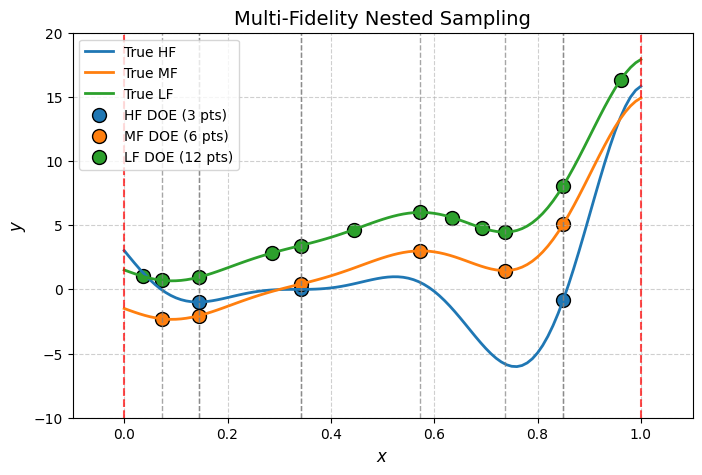

In [6]:
# LHS sampling with nested DOE: 3 levels, 1 dimension, 3 HF points
ndim = 1
nlvl = 3
ndoe_hf = 3

# Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=2)
Xt_c, Xt_m, Xt_e = xdoes(ndoe_hf)

ndoe_lf = np.shape(Xt_c)[0]
ndoe_mf = np.shape(Xt_m)[0]

# Expensive DOE with 3 points = Xt_e
# Intermediate DOE with 6 points = Xt_m
# Cheap DOE with 16 points Xt_c


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_m = MF_function(Xt_m)
yt_c = LF_function(Xt_c)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, HF_function(x), "-", label="True HF", color="C0", linewidth=2)
ax.plot(x, MF_function(x), "-", label="True MF", color="C1", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True LF", color="C2", linewidth=2)
ax.scatter(Xt_e, yt_e, marker="o", color="C0", edgecolor="k", s=100, label=f"HF DOE ({ndoe_hf} pts)")
ax.scatter(Xt_m, yt_m, marker="o", color="C1", edgecolor="k", s=100, label=f"MF DOE ({ndoe_mf} pts)")
ax.scatter(Xt_c, yt_c, marker="o", color="C2", edgecolor="k", s=100, label=f"LF DOE ({ndoe_lf} pts)")

for xe in Xt_e: # High
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1, alpha=0.7)
for xe in Xt_m: # Middle
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

ax.set_xlabel(r"$x$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
ax.set_title("Multi-Fidelity Nested Sampling", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
plt.show()
plt.close()

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1632824
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


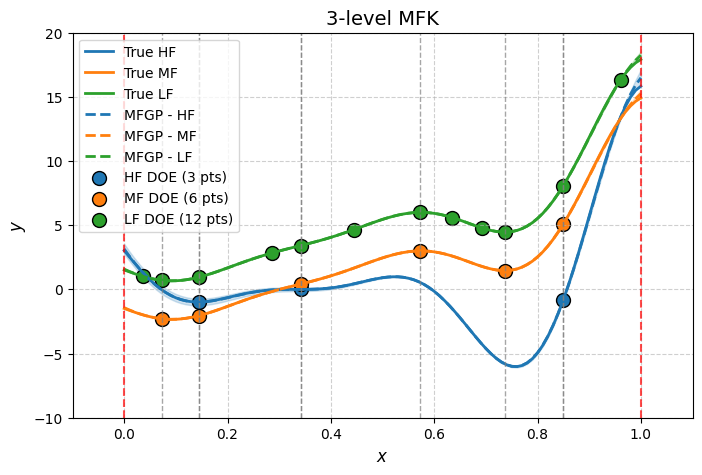

In [7]:
# Build the MFK object with 3 levels
sm = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt="TNC") # TNC
sm.set_training_values(Xt_c, yt_c, name=0) # low
sm.set_training_values(Xt_m, yt_m, name=1) # middle
sm.set_training_values(Xt_e, yt_e) # high
sm.train()


# test
nlvl = len(sm.X)
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

y = sm.predict_values(x)
y0 = sm._predict_intermediate_values(x, 1)
y1 = sm._predict_intermediate_values(x, 2)

var = sm.predict_variances(x)
varAll, _ = sm.predict_variances_all_levels(x)
var0 = varAll[:, 0].reshape(-1, 1)
var1 = varAll[:, 1].reshape(-1, 1)

# plot
fig, ax = plt.subplots(figsize=(8, 5))

# True functions
ax.plot(x, HF_function(x), "-", label="True HF", color="C0", linewidth=2)
ax.plot(x, MF_function(x), "-", label="True MF", color="C1", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True LF", color="C2", linewidth=2)

# MFK Predictions (Fixed color argument)
ax.plot(x, y, "--", color="C0", label="MFGP - HF", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
)

ax.plot(x, y1, "--", color="C1", label="MFGP - MF", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y1 - 3 * np.sqrt(var1)),
    np.ravel(y1 + 3 * np.sqrt(var1)),
    color="C1",
    alpha=0.2,
)

ax.plot(x, y0, "--", color="C2", label="MFGP - LF", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C2",
    alpha=0.2,
)

# Scatter plot with correct formatting
ax.scatter(np.ravel(Xt_e), np.ravel(yt_e), marker="o", color="C0", edgecolor="k", s=100, label=f"HF DOE ({len(Xt_e)} pts)")
ax.scatter(np.ravel(Xt_m), np.ravel(yt_m), marker="o", color="C1", edgecolor="k", s=100, label=f"MF DOE ({len(Xt_m)} pts)")
ax.scatter(np.ravel(Xt_c), np.ravel(yt_c), marker="o", color="C2", edgecolor="k", s=100, label=f"LF DOE ({len(Xt_c)} pts)")

# Vertical lines
for xe in np.ravel(Xt_e):  # High Fidelity
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1, alpha=0.7)
for xe in np.ravel(Xt_m):  # Middle Fidelity
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel(r"$x$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
ax.set_title("3-level MFK", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)

plt.show()
plt.close()

In [8]:
# to get some hyperparameter values
print("optimal theta:", sm.optimal_theta)

# to compute the variance of HF model at training points
y_train = sm.predict_values(Xt_e)
var_train = sm.predict_variances(Xt_e)
t_error = np.linalg.norm(y_train - yt_e) / np.linalg.norm(yt_e)
print("Relative prediction error on training points", t_error)
print("Variance at training points", np.linalg.norm(var_train))

optimal theta: [array([1.2237604]), array([1.e-06]), array([1.e-06])]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 3
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
Relative prediction error on training points 4.2406332332539907e-07
Variance at training points 0.00802414748942558
